# Implementation of K-means on [20 Newsgroups data set](http://qwone.com/~jason/20Newsgroups/)

In [1]:
import numpy as np
import pandas as pd
from itertools import islice
import collections
import datetime as dt 
from sklearn.model_selection import train_test_split
from sklearn import metrics
import K_Means_Algorithm as km
from sklearn.cluster import KMeans #for comparison
from sklearn.metrics import completeness_score, homogeneity_score

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set()

pd.set_option("display.precision", 2)

## Import data, test/train split

In [2]:
terms = pd.read_csv(".//data//News_groups_terms.txt", sep='\t', header=None) 
terms_lst = list(terms[0])
terms_lst[10:15]

['abomin', 'abort', 'abound', 'abraham', 'abridg']

In [3]:
#import the term (rows) X document (columns) matrix:
term_doc_matrix = pd.read_csv(".//data//News_groups_matrix.txt", sep=',', header = None) 
doc_term_matrix = term_doc_matrix.T
doc_term_matrix.columns = terms_lst
doc_term_matrix.head()

,aa,aargh,aaron,aaronc,ab,abandon,abc,abid,abil,abl,...,zq,zr,zrb,zs,zu,zubov,zv,zw,zx,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
doc_term_matrix.describe()

,aa,aargh,aaron,aaronc,ab,abandon,abc,abid,abil,abl,...,zq,zr,zrb,zs,zu,zubov,zv,zw,zx,zz
count,2.50e+03,2.50e+03,2500.00,2.50e+03,2500.00,2.50e+03,2500.00,2.50e+03,2500.00,2500.00,...,2.50e+03,2.50e+03,2.50e+03,2.50e+03,2.50e+03,2.50e+03,2500.00,2.50e+03,2.50e+03,2.50e+03
mean,6.40e-03,2.40e-03,0.03,4.80e-03,0.01,4.00e-03,0.02,1.60e-03,0.03,0.08,...,5.20e-03,6.40e-03,1.60e-03,7.60e-03,2.80e-03,3.20e-03,0.02,4.40e-03,2.40e-03,6.00e-03
std,1.38e-01,4.89e-02,0.95,8.47e-02,0.23,6.92e-02,0.25,4.90e-02,0.24,0.35,...,1.04e-01,1.88e-01,4.90e-02,1.95e-01,8.72e-02,6.92e-02,0.52,1.66e-01,8.48e-02,1.56e-01
min,0.00e+00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00
25%,0.00e+00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00
50%,0.00e+00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00
75%,0.00e+00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00e+00,0.00,0.00,...,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00e+00,0.00,0.00e+00,0.00e+00,0.00e+00
max,6.00e+00,1.00e+00,47.00,2.00e+00,9.00,2.00e+00,7.00,2.00e+00,6.00,4.00,...,3.00e+00,7.00e+00,2.00e+00,8.00e+00,3.00e+00,2.00e+00,20.00,8.00e+00,4.00e+00,5.00e+00


We can see that most terms show up sparsely across the documents.

In [5]:
# # Draw a heatmap with the numeric values in each cell
# f, ax = plt.subplots(figsize=(15, 20))
# sns.heatmap(doc_term_matrix.head(50), annot=False, fmt="d", linewidths=.5, ax=ax)

Unfortunately, the dataset is too large and sparse to visualize with a heatmap.

In [6]:
classes = pd.read_csv(".//data//News_groups_classes.txt", sep=' ', header=None, skiprows=1, index_col=0) 
classes.head()

,1
0,
0,0
1,1
2,1
3,1
4,2


In [7]:
print(doc_term_matrix.shape)
print(classes.shape)
print(terms.shape)

(2500, 9328)
(2500, 1)
(9328, 1)


In [8]:
doc_term_matrix_train, doc_term_matrix_test, classes_train, classes_test = train_test_split(doc_term_matrix, 
                                                                               classes, test_size=0.2, 
                                                                               random_state=33)

In [9]:
doc_term_matrix_train.shape, doc_term_matrix_test.shape

((2000, 9328), (500, 9328))

## Turn raw term frequencies into TFxIDF values 
(be sure to maintain DF values for each of the terms in the dictionary)

In [10]:
TD = doc_term_matrix_train.T

In [11]:
# Find document frequencies for each term
docFreq = np.array([(TD!=0).sum(1)]).T #counts nonzero entries for each term 
print(docFreq)

[[ 7]
 [ 4]
 [17]
 ...
 [ 2]
 [ 1]
 [ 2]]


In [12]:
len(np.where(docFreq == 0)[0])
# => there are 15 terms that don't appear in any documents!

15

In [13]:
NDocs = doc_term_matrix_train.shape[0]
NDocs

2000

In [14]:
# Create a matrix with all entries = NDocs
NMatrix=np.ones(np.shape(TD), dtype=float)*NDocs
np.set_printoptions(precision=2,suppress=True,linewidth=120)
print (NMatrix)

[[2000. 2000. 2000. ... 2000. 2000. 2000.]
 [2000. 2000. 2000. ... 2000. 2000. 2000.]
 [2000. 2000. 2000. ... 2000. 2000. 2000.]
 ...
 [2000. 2000. 2000. ... 2000. 2000. 2000.]
 [2000. 2000. 2000. ... 2000. 2000. 2000.]
 [2000. 2000. 2000. ... 2000. 2000. 2000.]]


In [15]:
# Convert each entry into IDF values
# Note that IDF is only a function of the term, so all columns will be identical.
IDF = np.log2(np.divide(NMatrix, docFreq)) 
print(IDF) 

C:\Users\renel.chesak\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


[[ 8.16  8.16  8.16 ...  8.16  8.16  8.16]
 [ 8.97  8.97  8.97 ...  8.97  8.97  8.97]
 [ 6.88  6.88  6.88 ...  6.88  6.88  6.88]
 ...
 [ 9.97  9.97  9.97 ...  9.97  9.97  9.97]
 [10.97 10.97 10.97 ... 10.97 10.97 10.97]
 [ 9.97  9.97  9.97 ...  9.97  9.97  9.97]]


Note above that there is a warning saying that it is encountering an issue where it has to divide by zero. This is actually creating INF (infinite) values where ever this happens. We encounter dividing by zero when the DF (NK) is zero (meaning the term doesn't appear in any documents). We need to replace these 'inf' values with some float to move on to the next step in our computation.

IDF provides high values for rare words and low values for common words, so infinite is appropriate, it just can't be used in computations. Two good options would be either making them really, really, big numbers, or removing them from the DT matrix altogether. We will proceed with the former.

In [16]:
#define inf:
positive_inf = float('+inf')

#set all inf values to a large number:
IDF[IDF == positive_inf] = 100000000000

In [17]:
# Finally compute the TFxIDF values for each document-term entry
#TD_tfidf = TD * IDF
TD_tfidf = np.multiply(TD, IDF)
TD_tfidf

,1289,596,1935,2436,2349,40,1018,502,1534,1445,...,2044,1422,1747,2109,102,2243,57,578,1752,2439
aa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aargh,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaron,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zubov,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zv,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can see above that most values are zero; this is a sparse matrix as noted earlier.

In [18]:
DT_tfidf = TD_tfidf.T
DT_tfidf.shape

(2000, 9328)

In [19]:
#drop rows (terms) where NULLs exist:
DT_tfidf_not_null = DT_tfidf[~np.isnan(DT_tfidf).any(axis=1)]
DT_tfidf_not_null.shape #NO NULLS EXIST! :D

(2000, 9328)

####  Create term-freqency dictionary:

In [20]:
numTerms = doc_term_matrix_train.shape[1]
numTerms

9328

In [21]:
dictTF = {terms_lst[i]:docFreq[i] for i in range(numTerms)}             
print(list(islice(dictTF.items(), 5)))

[('aa', array([7], dtype=int64)), ('aargh', array([4], dtype=int64)), ('aaron', array([17], dtype=int64)), ('aaronc', array([6], dtype=int64)), ('ab', array([9], dtype=int64))]


## Perform K-Means clustering on the training data 

In [22]:
#turn the matrix into a 2D numpy array
DT_tfidf = np.array(DT_tfidf) 

In [23]:
#run k-means
start = dt.datetime.now()
centroids, cluster = km.Train.KMeansClustering(DT_tfidf, k=5)
end = dt.datetime.now()
print('\nTime to compute: {}'.format(end-start))


Time to compute: 0:00:47.972943


In [24]:
cluster_counts_dict = collections.Counter(cluster[:, 0])
print("Number of docs in clusters:")
for key in cluster_counts_dict:
    print("Cluster", int(key), ':',  cluster_counts_dict[key])

Number of docs in clusters:
Cluster 2 : 786
Cluster 4 : 408
Cluster 0 : 405
Cluster 3 : 393
Cluster 1 : 8


In [25]:
#create arrays
doc_term_matrix_train_arr = np.array(doc_term_matrix_train)
terms_arr = np.array(terms_lst)

Can you guess which cluster is which based on the following categories?
- windows 
- crypt
- christian
- hockey
- forsale

In [26]:
#print results
km.Train.printDocClusterSummary(centroids, cluster, 10, doc_term_matrix_train_arr, terms_arr)

###############################################
Cluster: 0
	-----------------------
	Number of docs in cluster: 405
	-----------------------
	-----------------------
	Top N terms | % of docs in cluster that contain those terms
	-----------------------
	        kei | 45.9%
	    encrypt | 45.7%
	       chip | 38.8%
	      secur | 28.9%
	     govern | 33.6%
	    clipper | 45.7%
	    privaci | 12.3%
	     anonym | 4.7%
	  algorithm | 24.7%
	     system | 30.6%
###############################################

###############################################
Cluster: 1
	-----------------------
	Number of docs in cluster: 8
	-----------------------
	-----------------------
	Top N terms | % of docs in cluster that contain those terms
	-----------------------
	         ax | 87.5%
	        max | 87.5%
	         pl | 75.0%
	        giz | 75.0%
	        bxn | 75.0%
	         wm | 75.0%
	         qq | 75.0%
	         mq | 75.0%
	        asq | 75.0%
	        nui | 75.0%
##############################

#### using KMeans() from sklearn:

In [27]:
kmeans = KMeans(n_clusters=5, max_iter=500) 

In [28]:
kmeans.fit(DT_tfidf) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=500,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
#save cluster assignments
clusters_sklearn = kmeans.labels_

In [30]:
cluster_counts_dict = collections.Counter(clusters_sklearn)
print("Number of docs in clusters:")
for key in cluster_counts_dict:
    print("Cluster", int(key), ':',  cluster_counts_dict[key])

Number of docs in clusters:
Cluster 0 : 1994
Cluster 2 : 2
Cluster 3 : 1
Cluster 4 : 1
Cluster 1 : 2


These results are not at all similar to what the hand-built `KMeansClustering` function got. `sklearn`'s `KMeans` doesn't appear to work so well on this dataset.

## Compute the Completeness and Homogeneity values of the cluster assignments

In [31]:
#make the classes a 1D array so it can be compared with the cluster assignments
classes_train_arr = np.array(classes_train)
classes_train_arr = classes_train_arr.reshape(1, -1)
classes_train_arr = classes_train_arr[0]

In [32]:
#grab the cluster assignments from the K_Means() output:
cluster_assignments = cluster[:, 0]

In [33]:
completeness_score(classes_train_arr, cluster_assignments)

0.8491846979303588

It looks like our clusters have a good completeness score, and it is similar to an 85% accuracy score (based upon the true class assignments). A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster.

In [34]:
homogeneity_score(classes_train_arr, cluster_assignments)

0.715828717504507

The clusters have a pretty good homogeneity score; there is about a 72% "sameness" in each cluster. This means the clusters have pretty decent inter-cluster similarity. Overall, we can conclude that our algorithm did just about as well as whatever algorithm clustered them to create those 'true' classes.

## Investigate the quality of the clustering with Silhouete vales
One way to measure the quality of clustering is to compute the Silhouette values for each instance in the data. The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). It is the ratio of the difference between in-cluster dissimilarity and the closest out-of-cluster dissimilarity, and the maximum of these two values. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and well separated from other clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [35]:
silhouettes = metrics.silhouette_samples(DT_tfidf, cluster_assignments)

In [36]:
def plot_silhouettes(data, clusters, metric='euclidean'):

    cluster_labels = np.unique(clusters)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = metrics.silhouette_samples(data, clusters, metric='euclidean')
    c_ax_lower, c_ax_upper = 0, 0
    cticks = []
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[clusters == k]
        c_silhouette_vals.sort()
        c_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(c_ax_lower, c_ax_upper), c_silhouette_vals, height=1.0, 
                      edgecolor='none', color=color)

        cticks.append((c_ax_lower + c_ax_upper) / 2)
        c_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 

    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')

    plt.tight_layout()
    #plt.savefig('images/11_04.png', dpi=300)
    plt.show()

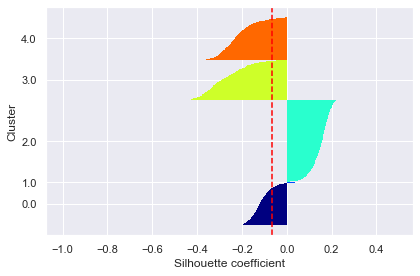

In [37]:
plot_silhouettes(DT_tfidf, cluster_assignments)

We can see from the silhouette plot that the clusters are not so different from eachother, and that is likely due to the sparsity of the matrix. Since most documents have zero occurences of most terms, the clusters appear to be a bit meaningless. Thus, due to the sparsity of the matrix, silhouette values don't provide much information and aren't so useful. It is more meaningful to see whether the clustering produced cluster assignments that match the ground-truth classes, which we saw in the completeness and homogeneity scores above.

## Categorize each of the documents in the test set
Here the hand-built `NearestNeighborClassifier()` is used to determine which cluster each document falls into. For this, the centroids generated from the hand-built `KMeansClustering()` function are used as the classes.

In [38]:
#create numpy array
doc_term_matrix_test_array = np.array(doc_term_matrix_test)
doc_term_matrix_test_array.shape

(500, 9328)

In [39]:
all_results, predicted_cluster_assignments = km.Train.NearestNeighborClassifier(centroids, doc_term_matrix_test_array)

In [40]:
#make the ground-truth classes a 1D array so it can be compared with the cluster assignments
classes_test_arr = np.array(classes_test)
classes_test_arr = classes_test_arr.reshape(1, -1)
classes_test_arr = classes_test_arr[0]

In [41]:
completeness_score(classes_test_arr, predicted_cluster_assignments)

0.8250147931195887

It looks like our clusters have a good completeness score, and it is similar to the 83% completeness score we got on the training set. It is normal for the test set to perform slightly worse, as some overfitting is part of the variance-bias tradeoff. 

Note: A clustering result satisfies completeness if all the data points that are members of a given class are elements of the same cluster. It is similar to an accuracy score because it's based on predicted vs. actual classes.

In [42]:
homogeneity_score(classes_test_arr, predicted_cluster_assignments)

0.6881070480516535

This result is also similar to what we got for the training set, so we are in good shape with our classifier.